In [1]:
import pandas as pd
import numpy as np

In [2]:
from datetime import datetime

In [3]:
import plotly.express as px

In [4]:
import plotly.io as pio
pio.renderers.default = "notebook"

In [5]:
csvs = [25, 24, 23, 22, 21, 20, 19]

In [6]:
# construct full time series from each year's df
dfs = []
for csv in csvs:
    path = f'passengers{csv}.csv'
    df = pd.read_csv(path)
    dfs.append(df)
all_data = pd.concat(dfs)

In [7]:
all_data.drop(columns=['Unnamed: 0'], axis=1).reset_index(drop=True).to_csv('all_data_raw.csv')

In [21]:
tsa_df = pd.read_csv('all_data_raw.csv', usecols=['date', 'passengers'])
tsa_df.head()

,date,passengers
0,1/1/2025,"2,313,111"
1,1/2/2025,"2,611,778"
2,1/3/2025,"2,561,917"
3,1/4/2025,"2,543,099"
4,1/5/2025,"2,579,257"


In [23]:
# convert date column to datetime
tsa_df['date'] = tsa_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
tsa_df.head()

,date,passengers
0,2025-01-01,"2,313,111"
1,2025-01-02,"2,611,778"
2,2025-01-03,"2,561,917"
3,2025-01-04,"2,543,099"
4,2025-01-05,"2,579,257"


In [24]:
# sort by date in ascending order
tsa_df = tsa_df.sort_values('date').reset_index(drop=True)
tsa_df

,date,passengers
0,2019-01-01,"2,201,765"
1,2019-01-02,"2,424,225"
2,2019-01-03,"2,279,384"
3,2019-01-04,"2,230,078"
4,2019-01-05,"2,049,460"
...,...,...
2363,2025-06-21,"2,545,281"
2364,2025-06-22,"3,096,293"
2365,2025-06-23,"2,953,920"
2366,2025-06-24,"2,508,700"


In [25]:
# create features for date
# not used in this analysis, but could potentially be useful
tsa_df['weekday'] = tsa_df['date'].apply(lambda x: x.weekday())
tsa_df['day'] = tsa_df['date'].apply(lambda x: x.timetuple()[2])
tsa_df['month'] = tsa_df['date'].apply(lambda x: x.timetuple()[1])
tsa_df['year'] = tsa_df['date'].apply(lambda x: x.timetuple()[0])
tsa_df.head(10)

,date,passengers,weekday,day,month,year
0,2019-01-01,"2,201,765",1,1,1,2019
1,2019-01-02,"2,424,225",2,2,1,2019
2,2019-01-03,"2,279,384",3,3,1,2019
3,2019-01-04,"2,230,078",4,4,1,2019
4,2019-01-05,"2,049,460",5,5,1,2019
5,2019-01-06,"2,299,648",6,6,1,2019
6,2019-01-07,"2,119,879",0,7,1,2019
7,2019-01-08,"1,805,496",1,8,1,2019
8,2019-01-09,"1,811,152",2,9,1,2019
9,2019-01-10,"2,029,644",3,10,1,2019


In [32]:
# only use data from 2022 on
cutoff = datetime(2022, 1, 1)

In [38]:
# the data clearly displays monthly seasonality
pd.set_option('display.float_format', '{:,.0f}'.format)
monthlies = tsa_df[tsa_df.date>=cutoff].groupby('day').agg({'passengers':'mean'})#.reset_index(inplace=True)#.sort_values('passengers')
monthlies.reset_index(inplace=True)
fig = px.line(monthlies, x='day', y='passengers')
fig.update_layout(title='Avg Passengers By Day of Month')
fig.update_yaxes(title='')
fig.update_xaxes(title='day')
fig.show()

In [39]:
# plot of full time series
fig = px.line(tsa_df[tsa_df.date>=cutoff], x='date', y='passengers', title='TSA vols')
fig.show()

In [118]:
from prophet import Prophet

In [119]:
# initialize model to get familiar with Prophet properties
model = Prophet(interval_width=0.95, changepoint_prior_scale=0.05)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5) # add monthly seasonality
model.add_country_holidays(country_name='US') # add holiday effects

In [120]:
# rename columns to fit with Prophet specs
df_to_fit = tsa_df[(tsa_df.date>=cutoff)]
df_to_fit.rename(columns={'date':'ds', 'passengers':'y'}, inplace=True)
df_to_fit.head()

,ds,y,weekday,day,month,year
1096,2022-01-01,"1,616,850",5,1,1,2022
1097,2022-01-02,"2,026,176",6,2,1,2022
1098,2022-01-03,"1,921,966",0,3,1,2022
1099,2022-01-04,"1,673,499",1,4,1,2022
1100,2022-01-05,"1,501,170",2,5,1,2022


In [121]:
# fit Prophet
model.fit(df_to_fit[['ds', 'y']])

01:16:54 - cmdstanpy - INFO - Chain [1] start processing
01:16:54 - cmdstanpy - INFO - Chain [1] done processing


In [122]:
# create dataframe with dates one year in the future
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
1632,2026-06-21
1633,2026-06-22
1634,2026-06-23
1635,2026-06-24
1636,2026-06-25


In [123]:
# forecast those values
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1632,2026-06-21,"2,416,902","2,697,184","3,156,761","2,332,667","2,510,440",0,0,0,0,...,"182,488","182,488","182,488","273,732","273,732","273,732",0,0,0,"2,918,770"
1633,2026-06-22,"2,416,802","2,575,434","3,087,911","2,332,177","2,510,692",0,0,0,0,...,"82,829","82,829","82,829","276,923","276,923","276,923",0,0,0,"2,836,829"
1634,2026-06-23,"2,416,701","2,256,777","2,751,388","2,331,686","2,510,943",0,0,0,0,...,"-259,863","-259,863","-259,863","278,913","278,913","278,913",0,0,0,"2,502,814"
1635,2026-06-24,"2,416,601","2,351,659","2,842,513","2,331,195","2,511,195",0,0,0,0,...,"-154,585","-154,585","-154,585","279,659","279,659","279,659",0,0,0,"2,602,517"
1636,2026-06-25,"2,416,501","2,648,618","3,141,771","2,330,705","2,511,447",0,0,0,0,...,"148,134","148,134","148,134","279,152","279,152","279,152",0,0,0,"2,889,312"


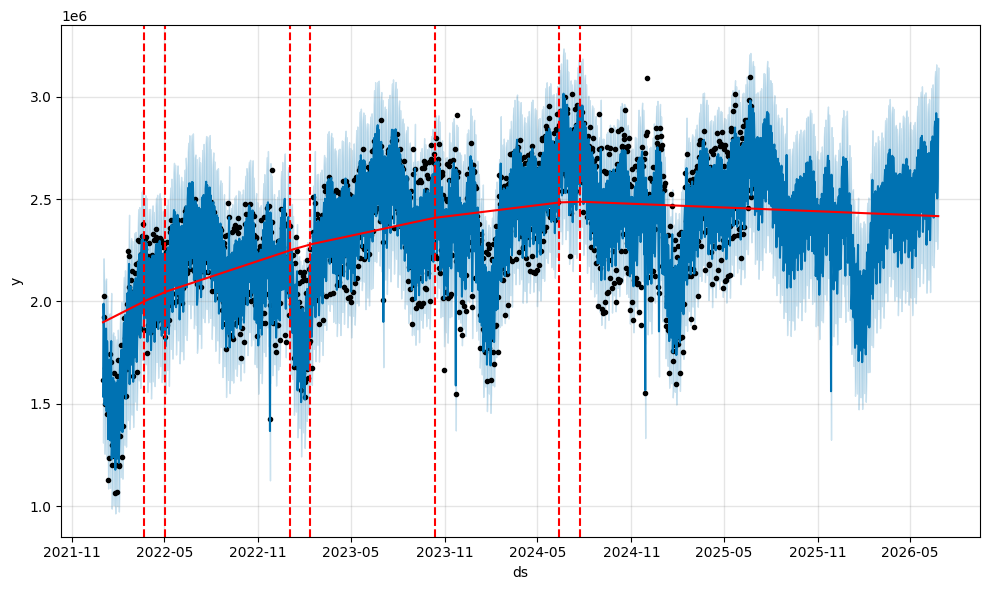

In [124]:
# visualize changepoints
from prophet.plot import add_changepoints_to_plot
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

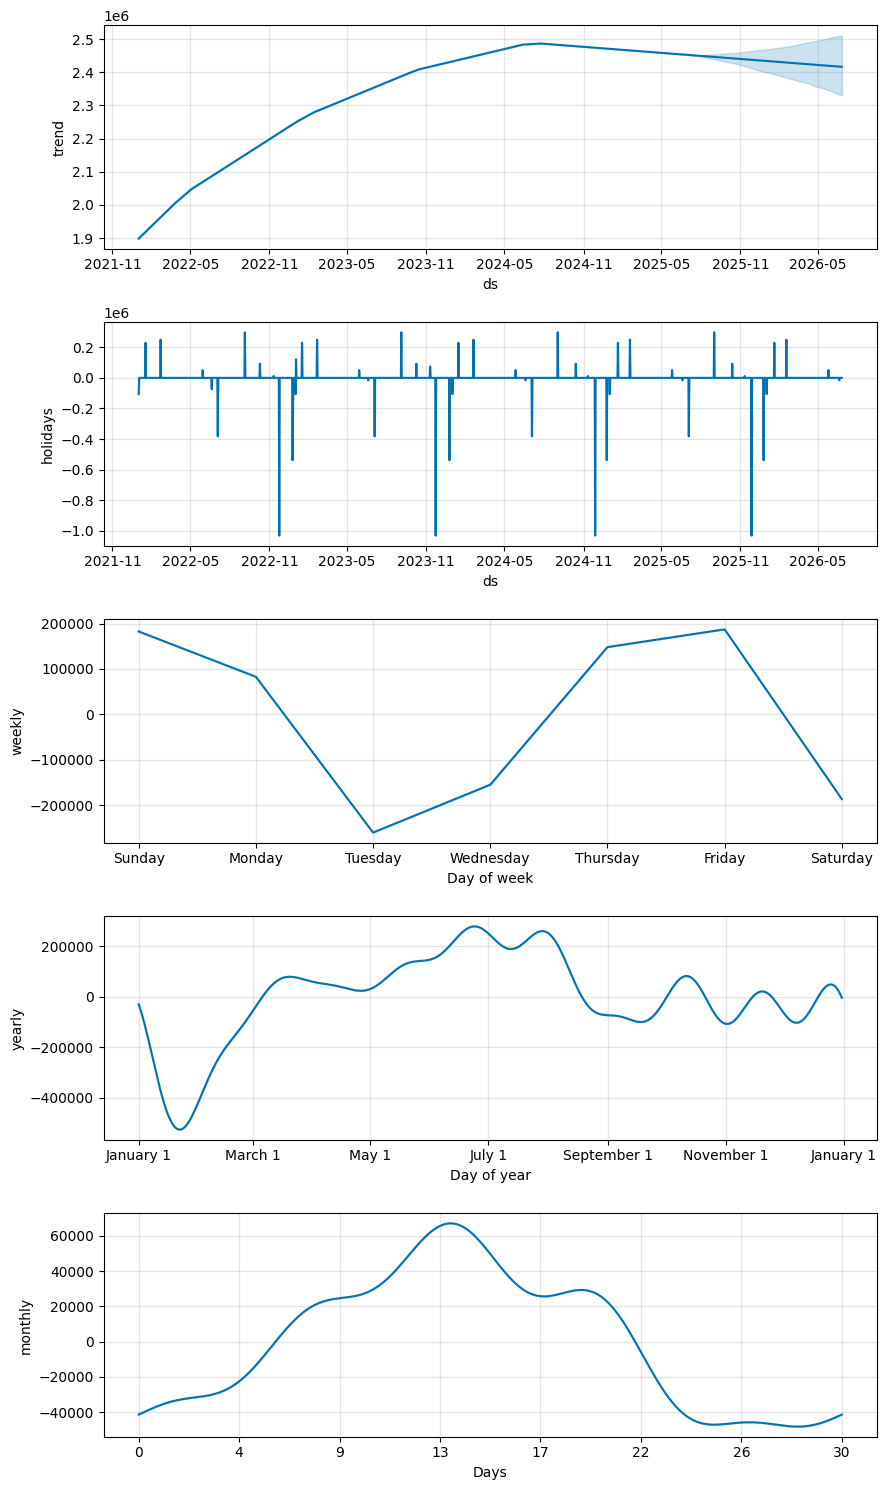

In [125]:
# visualize components
fig2 = model.plot_components(forecast)

In [48]:
# another visualization
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

In [126]:
# set up for validating Prophet with different hyperparameters
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

from datetime import timedelta
# start at first Monday in 2025, i.e. train on everything <= first Sunday
start = datetime(2025, 1, 5)

preds = []
while True:
    # break if the last week in the dataset is reached
    if start + timedelta(days=7) > datetime(2025, 6, 22):
        break

    # end date of forecasting window is 1 week
    end = start + timedelta(days=7)

    # initialize and fit Prophet
    model = Prophet(interval_width=0.95, changepoint_prior_scale=0.05) # alter changepoint to adjust trend flexibility
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_country_holidays(country_name='US')
    model.fit(df_to_fit[df_to_fit['ds']<=start][['ds', 'y']])
    
    # forecast next week
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future).tail(7)
    
    # save predictions
    preds.extend(forecast['yhat'].tolist())

    # advance one week and repeat
    start = start + timedelta(days=7)
print(preds)

01:20:22 - cmdstanpy - INFO - Chain [1] start processing
01:20:22 - cmdstanpy - INFO - Chain [1] done processing
01:20:22 - cmdstanpy - INFO - Chain [1] start processing
01:20:23 - cmdstanpy - INFO - Chain [1] done processing
01:20:23 - cmdstanpy - INFO - Chain [1] start processing
01:20:23 - cmdstanpy - INFO - Chain [1] done processing
01:20:23 - cmdstanpy - INFO - Chain [1] start processing
01:20:23 - cmdstanpy - INFO - Chain [1] done processing
01:20:23 - cmdstanpy - INFO - Chain [1] start processing
01:20:23 - cmdstanpy - INFO - Chain [1] done processing
01:20:23 - cmdstanpy - INFO - Chain [1] start processing
01:20:23 - cmdstanpy - INFO - Chain [1] done processing
01:20:23 - cmdstanpy - INFO - Chain [1] start processing
01:20:23 - cmdstanpy - INFO - Chain [1] done processing
01:20:24 - cmdstanpy - INFO - Chain [1] start processing
01:20:24 - cmdstanpy - INFO - Chain [1] done processing
01:20:24 - cmdstanpy - INFO - Chain [1] start processing
01:20:24 - cmdstanpy - INFO - Chain [1]

[2412992.3495991104, 2061867.0754666824, 2141083.2990929927, 2400340.8052425985, 2411056.01875442, 2016270.033337464, 2352110.067336209, 2192949.146181746, 1851410.149747992, 1934710.6046298537, 2200438.917153743, 2228134.89344784, 1862029.5954756185, 2228491.5565034645, 2336326.995279434, 1806153.863595325, 1896283.8337451164, 2170651.8721197867, 2208698.5958224665, 1851737.04370884, 2224325.9035699572, 2131745.89408428, 1801377.2535651322, 1893195.3637069012, 2176174.5909869205, 2225628.247647692, 1878414.4289274253, 2260653.546013655, 2175650.8736715717, 1862318.7351235114, 1980778.4518396822, 2292119.390504709, 2361395.846886416, 2020712.3945640635, 2402175.52072803, 2287831.7275913646, 1977310.0756002008, 2103680.651017155, 2420718.7455972037, 2489182.6508457614, 2142079.600502175, 2520041.342220145, 2655477.864747098, 2126551.7641497543, 2254053.6564290035, 2563515.518099959, 2613752.4005575464, 2245006.3301880667, 2605129.270167161, 2506322.2936204323, 2188711.2462808313, 229974

In [127]:
# y is actual values to compare against
y = np.array(df_to_fit[df_to_fit['ds']>datetime(2025,1,5)]['y'].tolist())[:-3]#[::-1]
preds = np.array(preds)

# print metrics
print('RMSE:', np.sqrt((np.sum(np.square(y-preds))) / len(y)))
print('MAE:', np.sum(np.abs(y-preds)) / len(y))
print('MEAN ERROR:', np.mean(y-preds))
print('MEDIAN ERROR:', np.percentile(y-preds, 50))

# plot histogram of validation errors
fig = px.histogram(y-preds)
fig.update_xaxes(title='error (actual - predicted)')
fig.update_layout(showlegend=False)
fig.show()

RMSE: 121522.98330469345
MAE: 95628.13204600137
MEAN ERROR: -31541.62063267665
MEDIAN ERROR: -23895.25049375603


In [173]:
def simulate(runs, means, stds):
    data = np.array([np.zeros(runs)])
    assert len(means) == len(stds)
    for i in range(len(means)):
        day_sims = np.random.normal(float(means[i]), float(stds[i]), runs)
        data = np.vstack((data, day_sims))
    return np.mean(data[1:], axis=0)

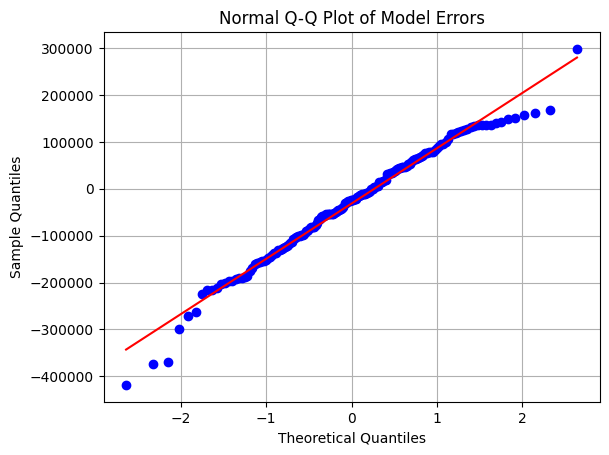

In [128]:
# produce normal qq plot of errors
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_qq(errors):
    stats.probplot(errors, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot of Model Errors")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

plot_qq(y-preds)

In [69]:
# merge forecasts with actual predictions to analyze errors over whole dataset
eval_df = pd.merge(left=forecast[(forecast.ds<datetime(2025,6,23))][['ds','yhat', 'yhat_lower', 'yhat_upper']],
                   right=tsa_df[['date', 'passengers']],
                   how='left', left_on='ds', right_on='date')
eval_df.head()                 

,ds,yhat,yhat_lower,yhat_upper,date,passengers
0,2022-01-01,"1,452,871","1,226,392","1,671,491",2022-01-01,"1,616,850"
1,2022-01-02,"1,894,961","1,671,995","2,127,339",2022-01-02,"2,026,176"
2,2022-01-03,"1,773,538","1,539,846","2,010,272",2022-01-03,"1,921,966"
3,2022-01-04,"1,408,867","1,170,748","1,641,179",2022-01-04,"1,673,499"
4,2022-01-05,"1,493,590","1,273,305","1,718,177",2022-01-05,"1,501,170"


In [70]:
# expected prediction error 
np.sqrt(np.sum(np.square(eval_df['yhat']-eval_df['passengers']))/len(eval_df))

np.float64(116302.2941889107)

In [71]:
eval_df['in_interval'] = np.where((eval_df['passengers'] < eval_df['yhat_upper'])&
                                  (eval_df['passengers'] > eval_df['yhat_lower']), 1, 0)

In [72]:
# check that actual values are within Prophet prediction interval roughly 95% of the time
sum(eval_df.in_interval) / len(eval_df)

0.9472025216706068

In [74]:
# calculate error of each prediction
eval_df['error'] = eval_df['passengers'] - eval_df['yhat']
eval_df.head()

,ds,yhat,yhat_lower,yhat_upper,date,passengers,in_interval,error
0,2022-01-01,"1,452,871","1,226,392","1,671,491",2022-01-01,"1,616,850",1,"163,979"
1,2022-01-02,"1,894,961","1,671,995","2,127,339",2022-01-02,"2,026,176",1,"131,215"
2,2022-01-03,"1,773,538","1,539,846","2,010,272",2022-01-03,"1,921,966",1,"148,428"
3,2022-01-04,"1,408,867","1,170,748","1,641,179",2022-01-04,"1,673,499",0,"264,632"
4,2022-01-05,"1,493,590","1,273,305","1,718,177",2022-01-05,"1,501,170",1,"7,580"


In [75]:
# plot errors over whole dataset
x = eval_df.ds
y = np.convolve(np.array(eval_df.error), np.ones(10)/10, mode='same')
fig = px.line(x=x, y=y)
fig.show()

In [ ]:
# plot 10 day moving average of validation errors over validation set
# still some seasonality, unfortunately
window_size = 10
ma = np.convolve(y-preds, np.ones(window_size)/window_size, mode='same')
fig = px.line(x=tsa_df[tsa_df['date']>datetime(2025,1,5)]['date'].tolist()[:-3], y=ma)
fig.update_layout(title='10-Day Moving Average of Errors')
fig.update_xaxes(title='date')
fig.update_yaxes(title='Centered MA10')
fig.show()

In [76]:
import statsmodels.api as sm
import statsmodels

In [82]:
# plot acf of errors
acf = statsmodels.tsa.stattools.acf(
    eval_df['error'],
    nlags=30
)

In [91]:
fig = px.bar(acf)
fig.update_layout(title='ACF of Train Errors', showlegend=False)
fig.update_yaxes(title='autocorrelation')
fig.update_xaxes(dtick=1, title='lag')
fig.show()

In [85]:
# plot pacf of errors
pacf = statsmodels.tsa.stattools.pacf(
    eval_df['error'],
    nlags=30
)

In [90]:
fig = px.bar(pacf)
fig.update_layout(title='PACF of Train Errors', showlegend=False)
fig.update_yaxes(title='autocorrelation')
fig.update_xaxes(dtick=1, title='lag')
fig.show()

In [ ]:
# before fitting, verify stationarity via ADF test
statsmodels.tsa.stattools.adfuller(eval_df['error'])

In [97]:
from statsmodels.tsa.arima.model import ARIMA

In [165]:
window_size = 10
ma = np.convolve(y-preds, np.ones(window_size)/window_size, mode='same')
fig = px.line(x=tsa_df[tsa_df['date']>datetime(2025,1,5)]['date'].tolist()[:-3], y=ma)
fig.update_layout(title='10-Day Moving Average of Errors')
fig.update_xaxes(title='date') 
fig.update_yaxes(title='Centered MA10')
fig.show()

In [116]:
# # set up for validating Prophet + ARMA with different hyperparameters
import warnings
warnings.filterwarnings('ignore')#, category=RuntimeWarning)

from datetime import timedelta

#start at first Monday in 2025, i.e. train on everything <= first Sunday
start = datetime(2025, 1, 5)

preds = []
vals = []
arma_preds = []
while True:
    # break if the last week in the dataset is reached
    if start + timedelta(days=7) > datetime(2025, 6, 25):
        break

    # end of forecasting window is 1 week out
    end = start + timedelta(days=7)

    # initialize and fit Prophet
    model = Prophet(interval_width=0.95, changepoint_prior_scale=0.05) # change trend flexibility to test different models
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_country_holidays(country_name='US')
    train = model.fit(df_to_fit[df_to_fit['ds']<=start][['ds', 'y']])
    future = train.make_future_dataframe(periods=7)
    forecast = train.predict(future)

    # compute errors of Prophet predictions in training set
    error_df = pd.merge(left=forecast[forecast.ds<=start][['ds','yhat', 'yhat_lower', 'yhat_upper']],
                   right=tsa_df[['date', 'passengers']],
                   how='left', left_on='ds', right_on='date')
    error_df['error'] = error_df['yhat'] - error_df['passengers']

    
    # prepare data for ARIMA
    arma_df = error_df[['ds', 'error']]
    arma_df.set_index('ds', inplace=True)

    # fit arma and forecast 1 week
    arma_mod = ARIMA(arma_df['error'], order=(14, 0, 14)).fit()
    arma_forecast = arma_mod.forecast(steps=7)

    # create preds by combining Prophet with ARMA
    week_preds = np.array(forecast[forecast.ds>start]['yhat'].tolist()) - np.array(arma_forecast)
    
    # store predictions
    preds.extend(week_preds)
    arma_preds.extend(arma_forecast)

    # repeat for next week
    start = start + timedelta(days=7)

22:07:44 - cmdstanpy - INFO - Chain [1] start processing
22:07:44 - cmdstanpy - INFO - Chain [1] done processing


3447.2434409257103


22:07:48 - cmdstanpy - INFO - Chain [1] start processing
22:07:48 - cmdstanpy - INFO - Chain [1] done processing


7086.535457531325


22:07:52 - cmdstanpy - INFO - Chain [1] start processing
22:07:52 - cmdstanpy - INFO - Chain [1] done processing


7163.761173653659


22:07:55 - cmdstanpy - INFO - Chain [1] start processing
22:07:55 - cmdstanpy - INFO - Chain [1] done processing


7029.591981582775


22:07:59 - cmdstanpy - INFO - Chain [1] start processing
22:07:59 - cmdstanpy - INFO - Chain [1] done processing


7519.027918237285


22:08:03 - cmdstanpy - INFO - Chain [1] start processing
22:08:03 - cmdstanpy - INFO - Chain [1] done processing


8481.98444486199


22:08:07 - cmdstanpy - INFO - Chain [1] start processing
22:08:07 - cmdstanpy - INFO - Chain [1] done processing


9503.28234481957


22:08:11 - cmdstanpy - INFO - Chain [1] start processing
22:08:11 - cmdstanpy - INFO - Chain [1] done processing


7107.851682680227


22:08:15 - cmdstanpy - INFO - Chain [1] start processing
22:08:15 - cmdstanpy - INFO - Chain [1] done processing


7781.280869137288


22:08:19 - cmdstanpy - INFO - Chain [1] start processing
22:08:19 - cmdstanpy - INFO - Chain [1] done processing


2495.0685132936032


22:08:23 - cmdstanpy - INFO - Chain [1] start processing
22:08:23 - cmdstanpy - INFO - Chain [1] done processing


1927.1646988617529


22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:08:28 - cmdstanpy - INFO - Chain [1] done processing


3306.3915976840976


22:08:32 - cmdstanpy - INFO - Chain [1] start processing
22:08:32 - cmdstanpy - INFO - Chain [1] done processing


547.0975972573972


22:08:36 - cmdstanpy - INFO - Chain [1] start processing
22:08:36 - cmdstanpy - INFO - Chain [1] done processing


-1338.3225493801576


22:08:40 - cmdstanpy - INFO - Chain [1] start processing
22:08:40 - cmdstanpy - INFO - Chain [1] done processing


-2884.7318586912575


22:08:44 - cmdstanpy - INFO - Chain [1] start processing
22:08:44 - cmdstanpy - INFO - Chain [1] done processing


-2249.61980878919


22:08:49 - cmdstanpy - INFO - Chain [1] start processing
22:08:49 - cmdstanpy - INFO - Chain [1] done processing


-998.2949108711547


22:08:53 - cmdstanpy - INFO - Chain [1] start processing
22:08:53 - cmdstanpy - INFO - Chain [1] done processing


-3386.9034268119826


22:08:57 - cmdstanpy - INFO - Chain [1] start processing
22:08:57 - cmdstanpy - INFO - Chain [1] done processing


-2345.368126008623


22:09:01 - cmdstanpy - INFO - Chain [1] start processing
22:09:02 - cmdstanpy - INFO - Chain [1] done processing


-9479.990699282273


22:09:06 - cmdstanpy - INFO - Chain [1] start processing
22:09:06 - cmdstanpy - INFO - Chain [1] done processing


-9609.227637100124


22:09:10 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing


880.5933302203866


22:09:14 - cmdstanpy - INFO - Chain [1] start processing
22:09:14 - cmdstanpy - INFO - Chain [1] done processing


472.7551116498575


22:09:19 - cmdstanpy - INFO - Chain [1] start processing
22:09:19 - cmdstanpy - INFO - Chain [1] done processing


-1404.8166346631117


In [117]:
# compute error metrics
y = np.array(tsa_df[tsa_df['date']>datetime(2025,1,5)]['passengers'].tolist())[:-3]#[::-1]
preds = np.array(preds)

print(np.sqrt((np.sum(np.square(y-preds))) / len(y)))
print(np.mean(np.abs(y-preds)))
print(np.mean(y-preds))
print(np.percentile(y-preds, 50))

115714.32056056558
85097.66909811771
-31315.006779707386
-20765.139397269348


,ds,y,weekday,day,month,year
2197,2025-01-06,"2,222,148",0,6,1,2025
2198,2025-01-07,"1,908,564",1,7,1,2025
2199,2025-01-08,"1,879,025",2,8,1,2025
2200,2025-01-09,"2,027,310",3,9,1,2025
2201,2025-01-10,"1,992,855",4,10,1,2025
2202,2025-01-11,"1,858,510",5,11,1,2025
2203,2025-01-12,"2,322,100",6,12,1,2025


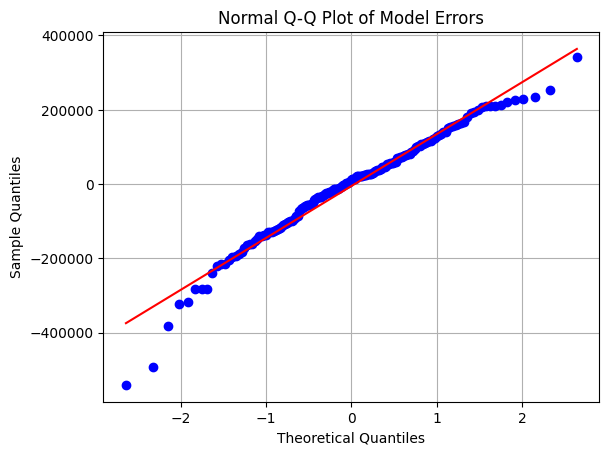

-5191.630272524326


In [68]:
# produce normal qq plot
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_qq(errors):
    stats.probplot(errors, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot of Model Errors")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

plot_qq(y-preds)
print(np.mean(y-preds))

In [80]:
# test simulation by fitting over whole dataset and simulating the next week

model = Prophet(interval_width=0.95, changepoint_prior_scale=0.05) 
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_country_holidays(country_name='US')
train = model.fit(df_to_fit[df_to_fit['ds']<=start][['ds', 'y']])
future = train.make_future_dataframe(periods=7)
forecast = train.predict(future)


error_df = pd.merge(left=forecast[forecast.ds<=start][['ds','yhat', 'yhat_lower', 'yhat_upper']],
               right=tsa_df[['date', 'passengers']],
               how='left', left_on='ds', right_on='date')
error_df['error'] = error_df['yhat'] - error_df['passengers']

arma_df = error_df[['ds', 'error']]
arma_df.set_index('ds', inplace=True)

arma_mod = ARIMA(arma_df['error'], order=(14, 0, 14)).fit()

22:14:26 - cmdstanpy - INFO - Chain [1] start processing
22:14:26 - cmdstanpy - INFO - Chain [1] done processing


2025-06-09   -32940.829758
2025-06-10    26468.260241
2025-06-11    16275.251415
2025-06-12   -54554.212080
2025-06-13   -37340.693495
2025-06-14    -9386.154290
2025-06-15   -43318.828686
Freq: D, Name: predicted_mean, dtype: float64


In [94]:
# simulate 100000 arma paths
from tqdm import tqdm
nsims = 100000
sims = np.array([np.zeros(7)])
for i in tqdm(range(nsims)):
    sims = np.vstack((sims, arma_mod.simulate(nsimulations=7, anchor=datetime(2025,6,23))))
sims

100%|████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:44<00:00, 960.10it/s]


array([[      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [-144804.85651441,  -99068.66642173, -144816.95647686, ...,
          -4585.74360877, -120141.32454717,   39799.14267858],
       [  82807.08517346,   85500.0468116 ,  -11677.40202253, ...,
         -61416.25628575,  114636.71978786,  119066.82812692],
       ...,
       [  16438.44438868,  149515.38092596,   86032.20484053, ...,
          89488.93763408,   55415.62950265,   13134.64882149],
       [ -71488.66594458,   10575.30424771,  -48593.01315774, ...,
          65891.87437295,  123240.899759  ,  -24074.55188652],
       [ -20832.12611009,   75090.30440028,  164126.70864132, ...,
          51729.46815852,  -56342.75521257,  -62328.15730987]],
      shape=(100001, 7))

In [95]:
sims = sims[1:]

In [103]:
# subtract from Prophet point estimates to get final model predictions
yhat = np.array(forecast.tail(7)['yhat'])
preds = yhat - sims
preds

array([[2850261.77270077, 2471425.84492912, 2628709.49511048, ...,
        2847164.69722692, 2596477.69547156, 2811911.46973192],
       [2622649.8310129 , 2286857.13169579, 2495569.94065615, ...,
        2903995.2099039 , 2361699.65113653, 2732643.78428359],
       [2765040.45803775, 2395578.49283803, 2497315.18857429, ...,
        2782383.5438052 , 2387208.35105685, 2986251.81929019],
       ...,
       [2689018.47179768, 2222841.79758143, 2397860.33379308, ...,
        2753090.01598407, 2420920.74142173, 2838575.96358902],
       [2776945.58213093, 2361781.87425968, 2532485.55179136, ...,
        2776687.0792452 , 2353095.47116538, 2875785.16429703],
       [2726289.04229645, 2297266.87410711, 2319765.8299923 , ...,
        2790849.48545963, 2532679.12613696, 2914038.76972038]],
      shape=(100000, 7))

In [104]:
# compute averages by week
avgs = np.mean(preds, axis=1)
avgs

array([2728987.03253608, 2598960.73622577, 2686702.40321245, ...,
       2600017.46182035, 2646830.09902788, 2619079.51776546],
      shape=(100000,))

In [111]:
# try calculating a fair value for a strike
np.sum(avgs > 2550000) / 100000

np.float64(0.98003)

(np.float64(-10.566239701828152),
 np.float64(7.504267411382915e-19),
 13,
 1255,
 {'1%': np.float64(-3.435571295403709),
  '5%': np.float64(-2.863845736356174),
  '10%': np.float64(-2.567997600196822)},
 np.float64(32267.355732368436))